## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [8]:
# Opening JSON file 
f = open("C:\\Users\\91984\\Desktop\\Upgrad Course Work\\Auto Ticket Classification Assignment\\complaints.json", 'r')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [9]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [10]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [11]:
#Assign new column names
df.rename(columns={'_source.complaint_what_happened':'customer_complaints'}, inplace = True)

In [12]:
#Assign nan in place of blanks in the complaints column
df.replace(r'^\s*$', np.nan, regex=True, inplace = True)

In [14]:
#Remove all rows where complaints column is nan
df = df[df['customer_complaints'].notna()]

In [15]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,customer_complaints,_source.sub_issue,_source.consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [21]:
# Write your function here to clean the text and remove all the unnecessary elements.
def text_clean_up(x):
    x = re.sub(r'\w*\d\w*', '', x).strip()
    x = x.translate(str.maketrans('', '', string.punctuation))
    return x

In [22]:
#Write your function to Lemmatize the texts
def lemmatize_text(x):
    buff = []
    d = nlp(x)
    for t in d:
        buff.append(t.lemma_)
    return ' '.join(buff)

In [23]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df['customer_complaints'] = df.apply(lambda x: text_clean_up(x['customer_complaints']), axis = 1)
df['customer_complaints_lemma'] = df.apply(lambda x: lemmatize_text(x['customer_complaints']), axis = 1)
df_clean = pd.DataFrame({'customer_complaints':df['customer_complaints'].tolist(), 'customer_complaints_lemma': df['customer_complaints_lemma'].tolist()})


In [62]:
df_clean = pd.DataFrame({'customer_complaints':df['customer_complaints'].tolist(), 'customer_complaints_lemma': df['customer_complaints_lemma'].tolist()})
df_clean.head()

,customer_complaints,customer_complaints_lemma
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX XXXX and I apprec...
1,I upgraded my XXXX XXXX card in XXXX and was t...,I upgrade my XXXX XXXX card in XXXX and be tel...
2,Chase Card was reported on XXXX However fraudu...,Chase Card be report on XXXX however fraudulen...
3,On XXXX while trying to book a XXXX XXXX tic...,on XXXX while try to book a XXXX XXXX tick...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [64]:
#Write your function to extract the POS tags 

def pos_tag(text):
    buff = []
    d = nlp(text)
    for t in d:
        if t.pos_ == 'NOUN':
            buff.append(t.orth_)
    return ' '.join(buff)



df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: pos_tag(x['customer_complaints_lemma']), axis = 1)

In [65]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,customer_complaints,customer_complaints_lemma,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX XXXX and I apprec...,morning name stop cardmember service debt veri...
1,I upgraded my XXXX XXXX card in XXXX and was t...,I upgrade my XXXX XXXX card in XXXX and be tel...,XXXX card agent anniversary date agent informa...
2,Chase Card was reported on XXXX However fraudu...,Chase Card be report on XXXX however fraudulen...,report application identity consent service cr...
3,On XXXX while trying to book a XXXX XXXX tic...,on XXXX while try to book a XXXX XXXX tick...,XXXX ticket offer ticket reward card informati...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [28]:
!pip install wordcloud

In [29]:
# Write your code here to visualise the data according to the 'Complaint' character length
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud
import collections


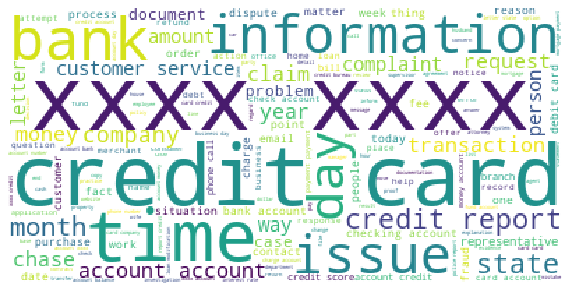

In [32]:
word_corpus = '\n'.join(df_clean["complaint_POS_removed"].tolist())
wordcloud = WordCloud(background_color="white", max_words=1000).generate(word_corpus)
rcParams['figure.figsize'] = 10, 20
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [34]:
filtered_words = [word for word in word_corpus.split()]
counted_words = collections.Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(40):
    words.append(letter)
    counts.append(count)

<BarContainer object of 40 artists>

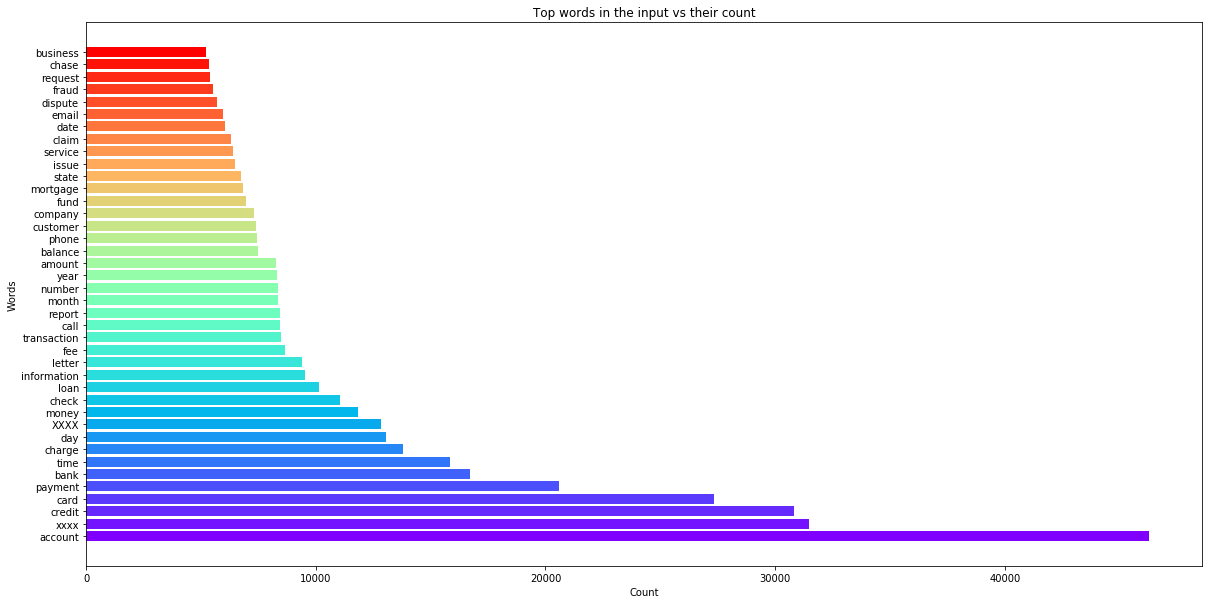

In [36]:
colors = cm.rainbow(np.linspace(0, 1, 40))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in the input vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [67]:
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

In [68]:
#All masked texts has been removed
df_clean.head()

,customer_complaints,customer_complaints_lemma,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX XXXX and I apprec...,morning name stop cardmember service debt veri...
1,I upgraded my XXXX XXXX card in XXXX and was t...,I upgrade my XXXX XXXX card in XXXX and be tel...,XXXX card agent anniversary date agent informa...
2,Chase Card was reported on XXXX However fraudu...,Chase Card be report on XXXX however fraudulen...,report application identity consent service cr...
3,On XXXX while trying to book a XXXX XXXX tic...,on XXXX while try to book a XXXX XXXX tick...,XXXX ticket offer ticket reward card informati...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [69]:
#Write your code here to initialise the TfidfVectorizer 
vect = TfidfVectorizer(stop_words='english', max_df = 0.95, min_df = 2)



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [95]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
X = vect.fit_transform(df_clean['complaint_POS_removed'].tolist())

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [71]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [96]:
#Load your nmf_model with the n_components i.e 5
N_TOPICS = 5

#keep the random_state =40
nmf_model = NMF(n_components=N_TOPICS, random_state = 40)
W = nmf_model.fit_transform(X)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix

C:\Users\91984\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:315: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



In [97]:
#Print the Top15 words for each of the topics
words = np.array(vect.get_feature_names())
topic_words = pd.DataFrame(np.zeros((N_TOPICS, 15)), index=[f'Topic {i}' for i in range(N_TOPICS)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(N_TOPICS):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 0,account,check,bank,money,fund,deposit,day,branch,checking,number,business,transaction,transfer,chase,customer
Topic 1,card,credit,balance,account,chase,limit,year,score,point,purchase,month,offer,application,reason,customer
Topic 2,payment,loan,mortgage,month,time,home,modification,year,balance,rate,statement,property,xxxx,date,day
Topic 3,report,credit,inquiry,information,company,account,debt,bureaus,score,letter,identity,reporting,remove,date,file
Topic 4,charge,dispute,transaction,fee,merchant,claim,xxxx,fraud,purchase,email,refund,company,service,time,day


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [98]:
#Create the best topic for each complaint
topic_mapping = {
    'Topic 0': 'Bank Account services',
    'Topic 1': 'Credit card or prepaid card',
    'Topic 2': 'Mortgage/Loan',
    'Topic 3': 'Others',
    'Topic 4': 'Theft/Dispute Reporting'
}


In [99]:
W = pd.DataFrame(W, columns=[f'Topic {i}' for i in range(N_TOPICS)])
W['max_topic'] = W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)
W.head(10)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,max_topic
0,0.017994,0.000644,0.015184,0.015847,0.008954,Bank Account services
1,0.008684,0.015401,0.004577,0.002267,0.011242,Credit card or prepaid card
2,0.000000,0.004591,0.000000,0.057628,0.000000,Others
3,0.016225,0.029119,0.004062,0.042601,0.007414,Others
4,0.073678,0.001443,0.001726,0.000000,0.000000,Bank Account services
5,0.000000,0.000000,0.000000,0.115130,0.000000,Others
6,0.062791,0.005960,0.015160,0.000000,0.003055,Bank Account services
7,0.005544,0.004630,0.061099,0.000000,0.007785,Mortgage/Loan
8,0.022168,0.000000,0.009801,0.018816,0.061982,Theft/Dispute Reporting
9,0.000000,0.068430,0.000000,0.084578,0.000000,Others


In [100]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W['max_topic'].tolist()

In [101]:
df_clean.head()

,customer_complaints,customer_complaints_lemma,complaint_POS_removed,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning my name be XXXX XXXX and I apprec...,morning name stop cardmember service debt veri...,Bank Account services
1,I upgraded my XXXX XXXX card in XXXX and was t...,I upgrade my XXXX XXXX card in XXXX and be tel...,XXXX card agent anniversary date agent informa...,Credit card or prepaid card
2,Chase Card was reported on XXXX However fraudu...,Chase Card be report on XXXX however fraudulen...,report application identity consent service cr...,Others
3,On XXXX while trying to book a XXXX XXXX tic...,on XXXX while try to book a XXXX XXXX tick...,XXXX ticket offer ticket reward card informati...,Others
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,Bank Account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [102]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

labels = le.fit_transform(df_clean['Topic'].tolist())

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
lr = LogisticRegression(random_state=40)
dtc = DecisionTreeClassifier(random_state=40)
rfc = RandomForestClassifier(max_depth=20, bootstrap = True, max_samples = 0.4, random_state=40)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.4, random_state=40, stratify = labels)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [104]:
# Write your code here to build any 3 models and evaluate them using the required metrics
lr.fit(X_train, y_train)
dtc.fit(X_train, y_train)
rfc.fit(X_train, y_train)


C:\Users\91984\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



RandomForestClassifier(max_depth=20, max_samples=0.4, random_state=40)

In [105]:
from sklearn.metrics import precision_recall_fscore_support
lpreds = lr.predict(X_test)
dtcpreds = dtc.predict(X_test)
rfcpreds = rfc.predict(X_test)

## Logistic Regression Performance

In [106]:
precision_recall_fscore_support(y_test, lpreds, average='weighted')

(0.9587435562941441, 0.9583580495906988, 0.9583603882297254, None)

# Decision Tree Performance

In [107]:
precision_recall_fscore_support(y_test, dtcpreds, average='weighted')

(0.8408460544297408, 0.8405504804840432, 0.8406337870894164, None)

# Random Forest Performance

In [108]:
precision_recall_fscore_support(y_test, rfcpreds, average='weighted')

(0.8328897889599929, 0.8247716217819433, 0.8222831946196806, None)

## Logistic Regression seems to have better performance. We may get better performance out of Random Forest with hyperparameter tuning (max_features, min_leaf_split, etc.)